# Fraud Detection Transactions Dataset

21 features capturing various aspects of a financial transaction

Realistic structure with numerical, categorical, and temporal data

Binary fraud labels (0 = Not Fraud, 1 = Fraud)

Designed for high accuracy with XGBoost and other ML models

Useful for anomaly detection, risk analysis, and security research


# Potential Use Cases
Fraud detection model training


Anomaly detection in financial transactions

Risk scoring systems for banks and fintech companies

Feature engineering and model explainability research

In [1]:
# !pip install lightgbm


In [2]:
# %pip install optuna xgboost lightgbm scikit-learn shap


In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, minmax_scale, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

## model imports
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# evaluvation matrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# for hyper parameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold

# saving the model 
import joblib
import os
import pickle
import warnings
warnings.filterwarnings('ignore')


In [4]:
data = pd.read_csv(r'synthetic_fraud_dataset.csv')

In [5]:
data 

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Timestamp,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,...,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Type,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label
0,TXN_33553,USER_1834,39.79,POS,2023-08-14 19:30:00,93213.17,Laptop,Sydney,Travel,0,...,7,437.63,3,Amex,65,883.17,Biometric,0.8494,0,0
1,TXN_9427,USER_7875,1.19,Bank Transfer,2023-06-07 04:01:00,75725.25,Mobile,New York,Clothing,0,...,13,478.76,4,Mastercard,186,2203.36,Password,0.0959,0,1
2,TXN_199,USER_2734,28.96,Online,2023-06-20 15:25:00,1588.96,Tablet,Mumbai,Restaurants,0,...,14,50.01,4,Visa,226,1909.29,Biometric,0.8400,0,1
3,TXN_12447,USER_2617,254.32,ATM Withdrawal,2023-12-07 00:31:00,76807.20,Tablet,New York,Clothing,0,...,8,182.48,4,Visa,76,1311.86,OTP,0.7935,0,1
4,TXN_39489,USER_2014,31.28,POS,2023-11-11 23:44:00,92354.66,Mobile,Mumbai,Electronics,0,...,14,328.69,4,Mastercard,140,966.98,Password,0.3819,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,TXN_11284,USER_4796,45.05,Online,2023-01-29 18:38:00,76960.11,Mobile,Tokyo,Clothing,0,...,2,389.00,3,Amex,98,1537.54,PIN,0.1493,1,0
49996,TXN_44732,USER_1171,126.15,POS,2023-05-09 08:55:00,28791.75,Mobile,Tokyo,Clothing,0,...,13,434.95,4,Visa,93,2555.72,Biometric,0.3653,0,1
49997,TXN_38158,USER_2510,72.02,Online,2023-01-30 19:32:00,29916.41,Laptop,Mumbai,Clothing,0,...,1,369.15,2,Visa,114,4686.59,Biometric,0.5195,0,0
49998,TXN_860,USER_2248,64.89,Bank Transfer,2023-03-09 19:47:00,67895.67,Mobile,Tokyo,Electronics,0,...,13,242.29,4,Discover,72,4886.92,Biometric,0.7063,0,1


In [6]:
data.shape

(50000, 21)

In [7]:
data.isna().sum()

Transaction_ID                  0
User_ID                         0
Transaction_Amount              0
Transaction_Type                0
Timestamp                       0
Account_Balance                 0
Device_Type                     0
Location                        0
Merchant_Category               0
IP_Address_Flag                 0
Previous_Fraudulent_Activity    0
Daily_Transaction_Count         0
Avg_Transaction_Amount_7d       0
Failed_Transaction_Count_7d     0
Card_Type                       0
Card_Age                        0
Transaction_Distance            0
Authentication_Method           0
Risk_Score                      0
Is_Weekend                      0
Fraud_Label                     0
dtype: int64

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Transaction_ID                50000 non-null  object 
 1   User_ID                       50000 non-null  object 
 2   Transaction_Amount            50000 non-null  float64
 3   Transaction_Type              50000 non-null  object 
 4   Timestamp                     50000 non-null  object 
 5   Account_Balance               50000 non-null  float64
 6   Device_Type                   50000 non-null  object 
 7   Location                      50000 non-null  object 
 8   Merchant_Category             50000 non-null  object 
 9   IP_Address_Flag               50000 non-null  int64  
 10  Previous_Fraudulent_Activity  50000 non-null  int64  
 11  Daily_Transaction_Count       50000 non-null  int64  
 12  Avg_Transaction_Amount_7d     50000 non-null  float64
 13  F

# EDA 
### Univariate Analysis

### identifying the numarical and the catagorical columns

In [9]:
numeric_cols = data.select_dtypes(include = ['int64', 'float64']).columns.tolist()
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

Numeric columns: ['Transaction_Amount', 'Account_Balance', 'IP_Address_Flag', 'Previous_Fraudulent_Activity', 'Daily_Transaction_Count', 'Avg_Transaction_Amount_7d', 'Failed_Transaction_Count_7d', 'Card_Age', 'Transaction_Distance', 'Risk_Score', 'Is_Weekend', 'Fraud_Label']
Categorical columns: ['Transaction_ID', 'User_ID', 'Transaction_Type', 'Timestamp', 'Device_Type', 'Location', 'Merchant_Category', 'Card_Type', 'Authentication_Method']


### Univarient Analyses on the Numarical features

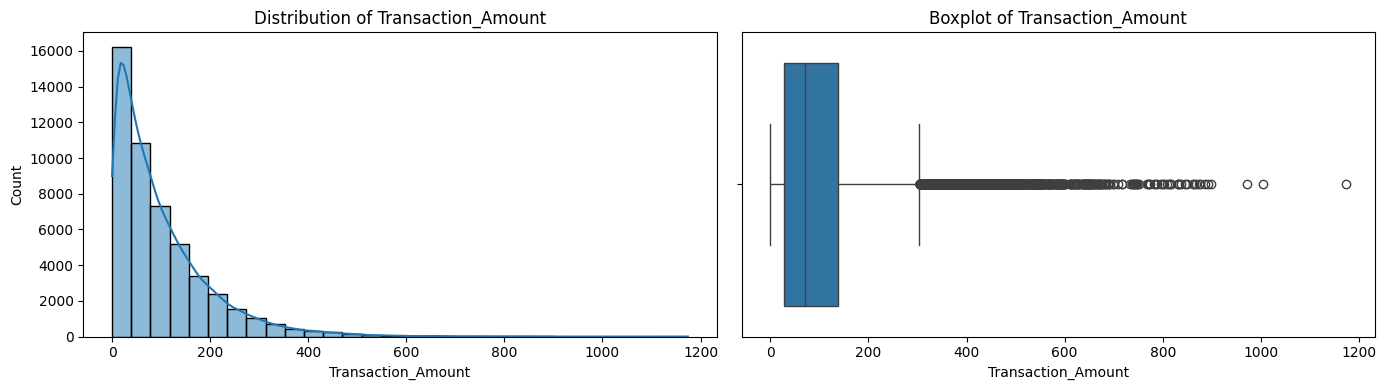

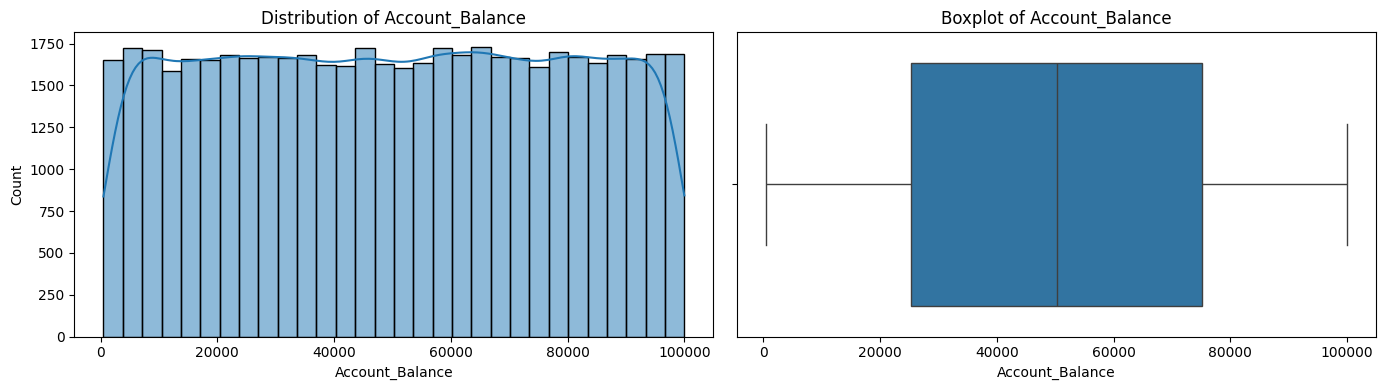

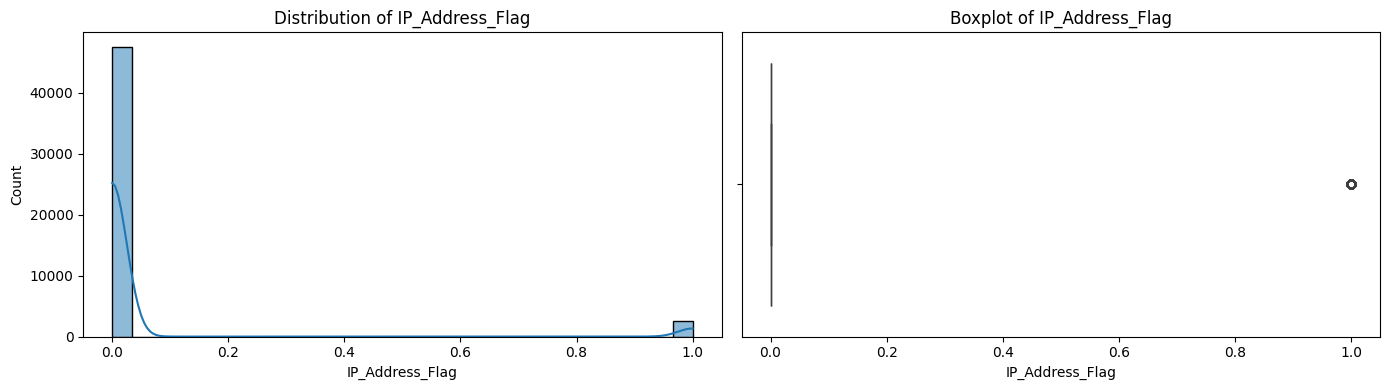

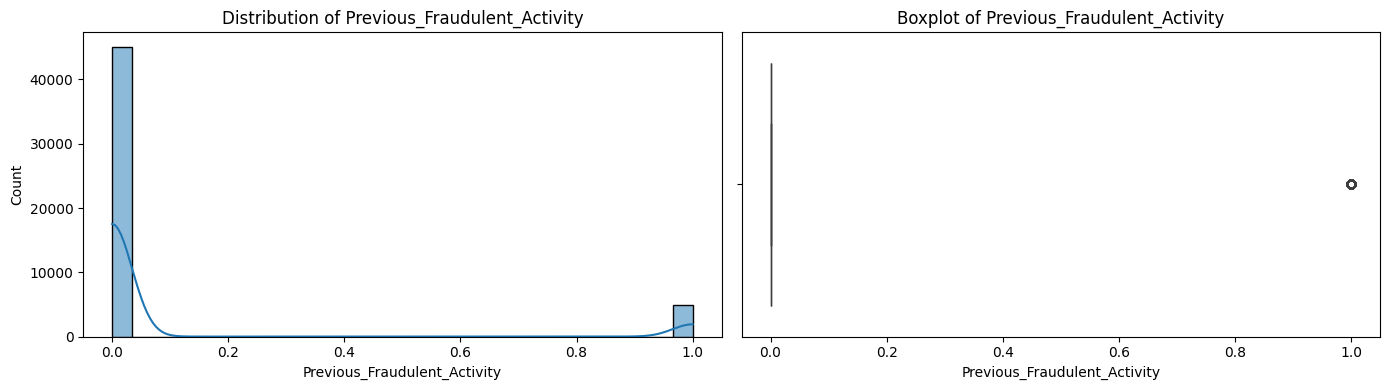

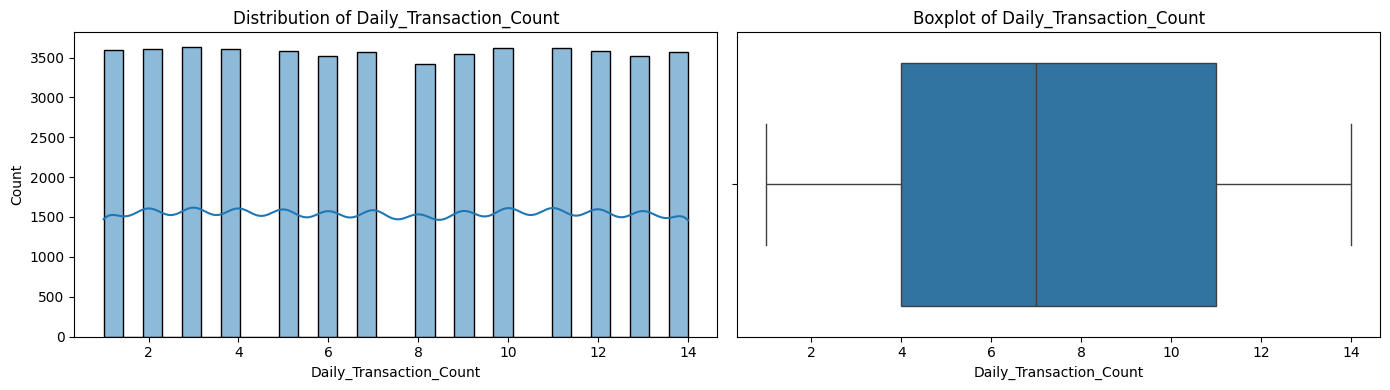

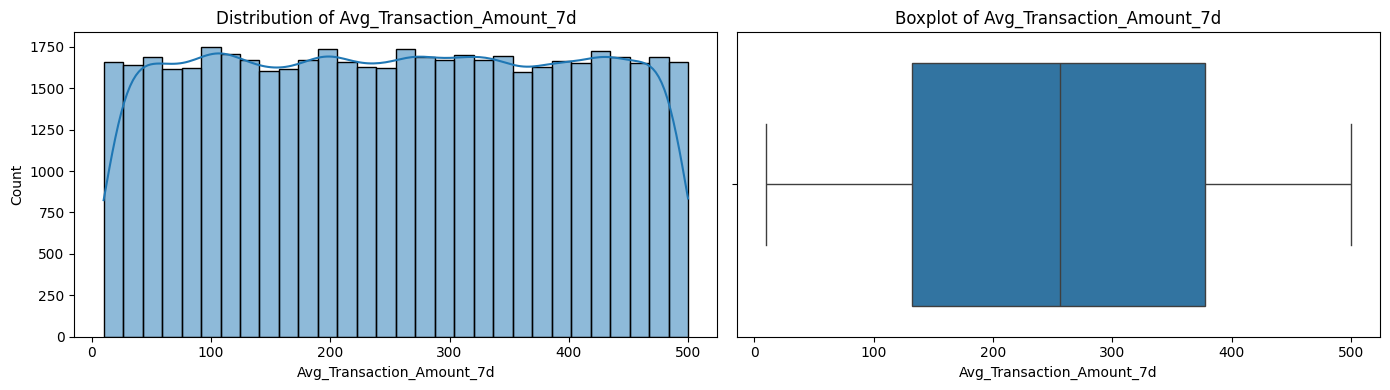

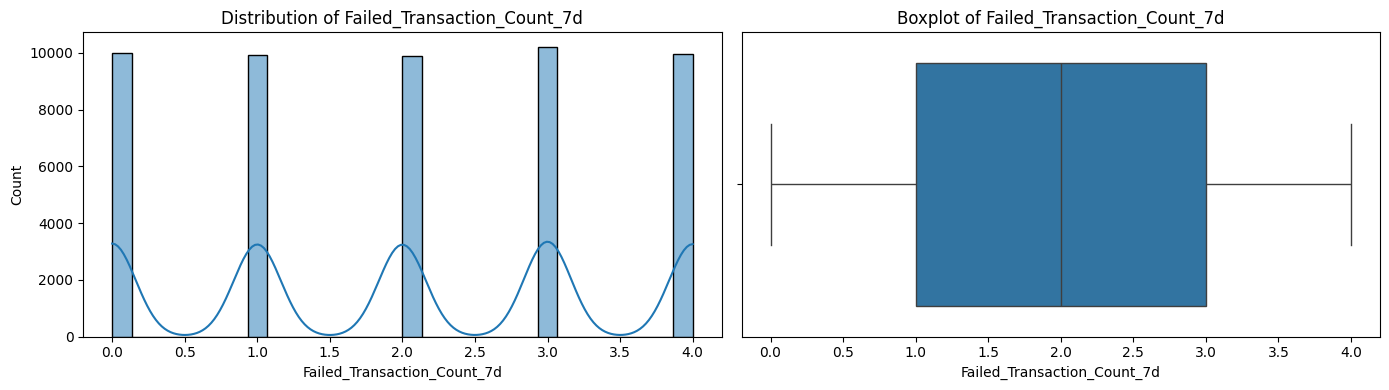

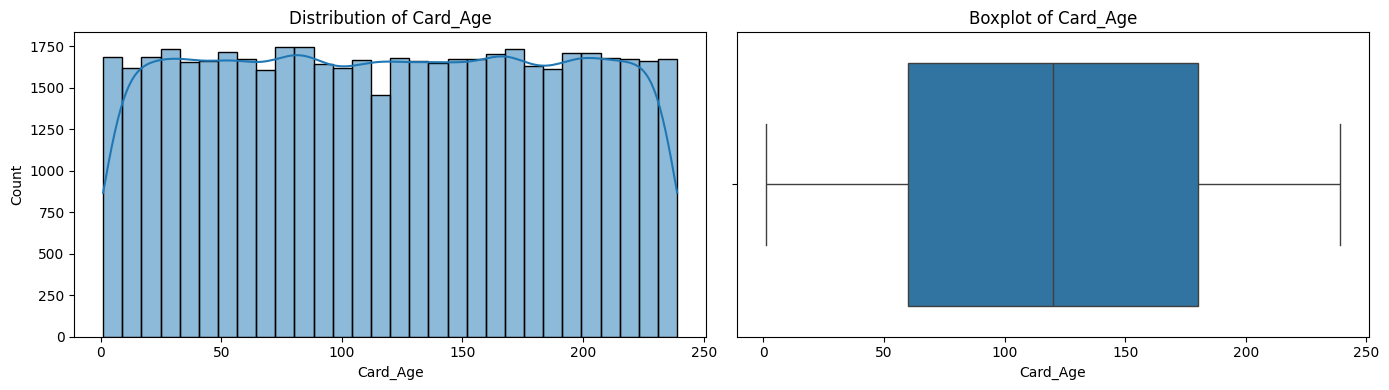

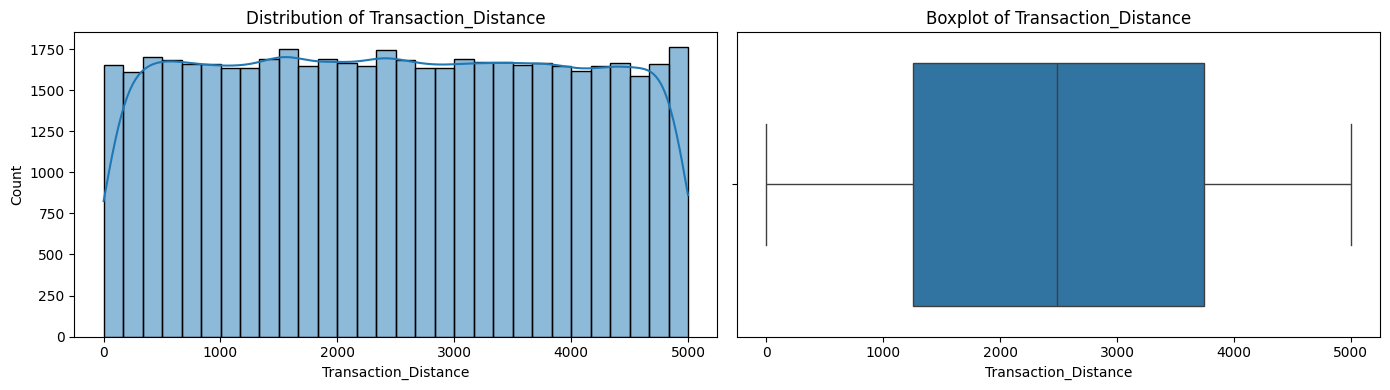

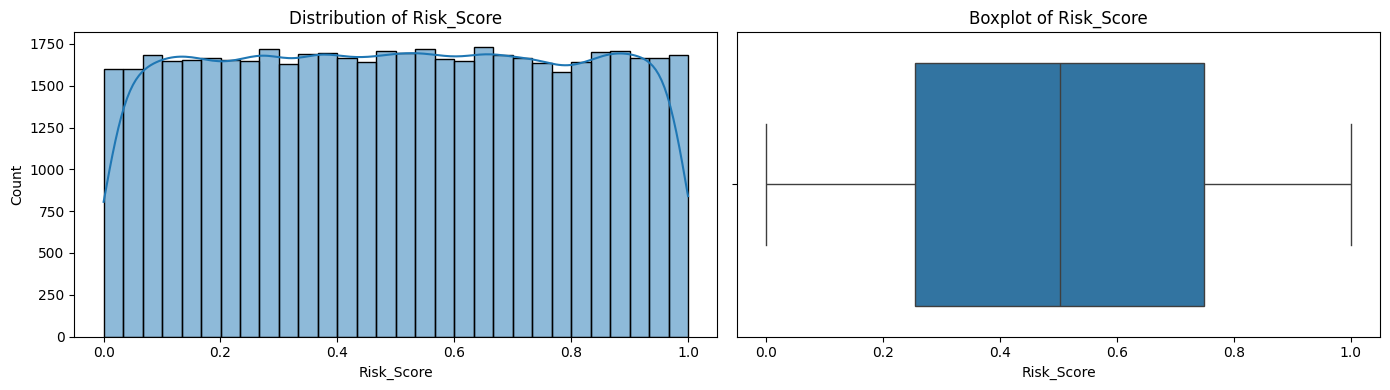

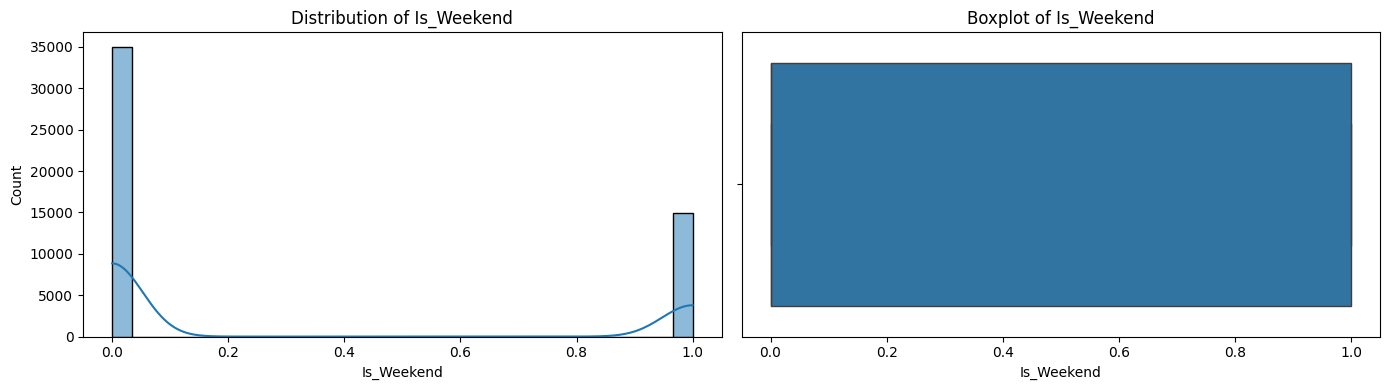

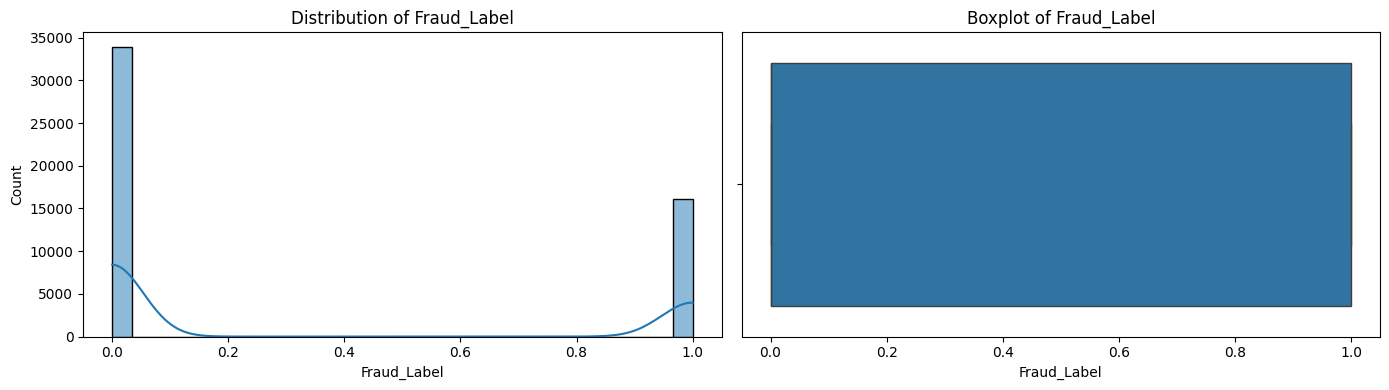

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

for col in numeric_cols:
    plt.figure(figsize=(14, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(data[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[col])
    plt.title(f"Boxplot of {col}")

    plt.tight_layout()
    plt.show()


In [11]:
## appling the log transformation on the skewed features
data['Transaction_Amount_Log'] = np.log1p(data['Transaction_Amount'])


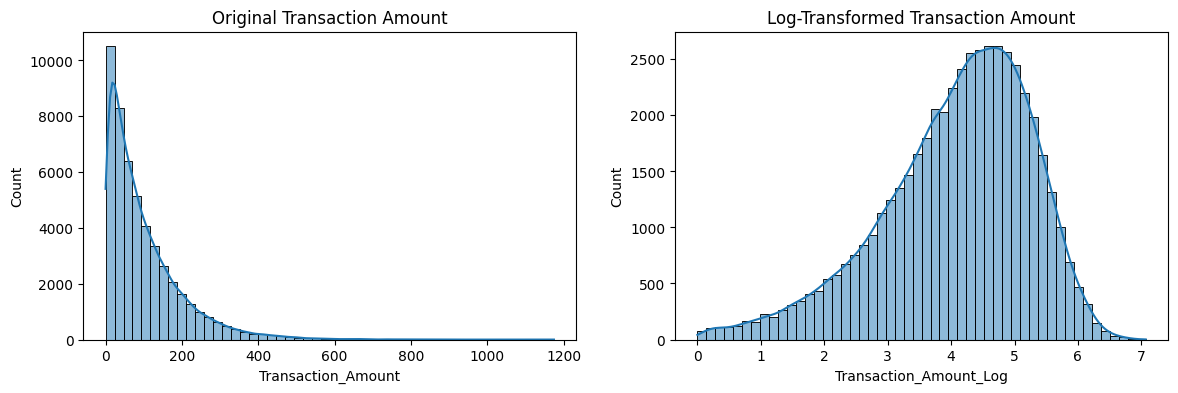

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))

sns.histplot(data['Transaction_Amount'], bins=50, kde=True, ax=ax[0])
ax[0].set_title("Original Transaction Amount")

sns.histplot(data['Transaction_Amount_Log'], bins=50, kde=True, ax=ax[1])
ax[1].set_title("Log-Transformed Transaction Amount")

plt.show()


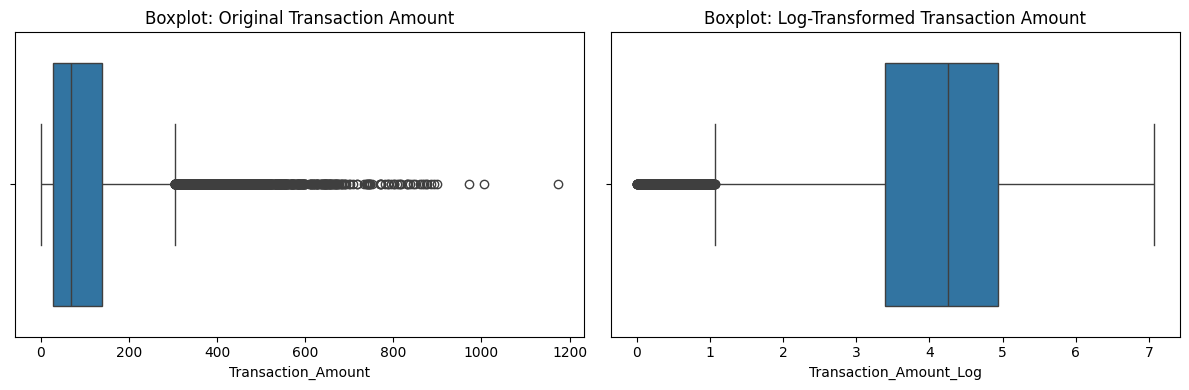

In [13]:
plt.figure(figsize=(12,4))

# Original Amount Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x=data['Transaction_Amount'])
plt.title("Boxplot: Original Transaction Amount")

# Log Amount Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=data['Transaction_Amount_Log'])
plt.title("Boxplot: Log-Transformed Transaction Amount")

plt.tight_layout()
plt.show()


In [14]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Transaction_ID                50000 non-null  object 
 1   User_ID                       50000 non-null  object 
 2   Transaction_Amount            50000 non-null  float64
 3   Transaction_Type              50000 non-null  object 
 4   Timestamp                     50000 non-null  object 
 5   Account_Balance               50000 non-null  float64
 6   Device_Type                   50000 non-null  object 
 7   Location                      50000 non-null  object 
 8   Merchant_Category             50000 non-null  object 
 9   IP_Address_Flag               50000 non-null  int64  
 10  Previous_Fraudulent_Activity  50000 non-null  int64  
 11  Daily_Transaction_Count       50000 non-null  int64  
 12  Avg_Transaction_Amount_7d     50000 non-null  float64
 13  F

#### Univariate Analysis — Categorical Features

In [15]:
data['Location'].unique()


array(['Sydney', 'New York', 'Mumbai', 'Tokyo', 'London'], dtype=object)

In [16]:
data['Location'].nunique()


5

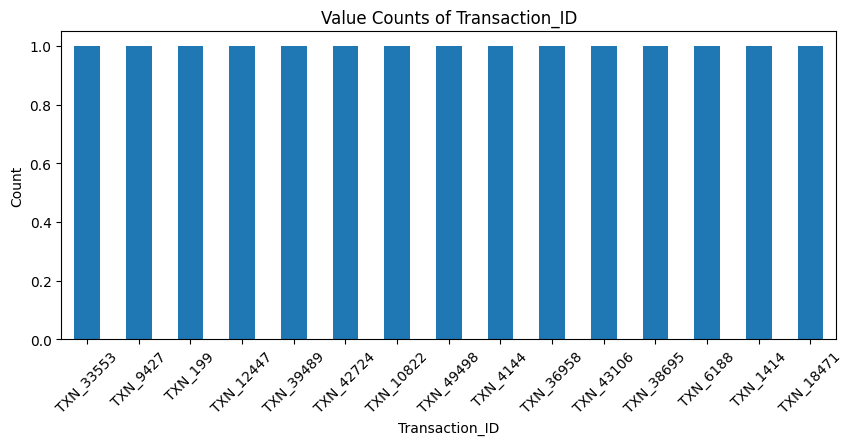

Unique values in 'Transaction_ID': 50000

Value counts for Transaction_ID:
 Transaction_ID
TXN_33553    1
TXN_9427     1
TXN_199      1
TXN_12447    1
TXN_39489    1
            ..
TXN_11284    1
TXN_44732    1
TXN_38158    1
TXN_860      1
TXN_15795    1
Name: count, Length: 50000, dtype: int64

Top 10 values for Transaction_ID:
 Transaction_ID
TXN_33553    1
TXN_9427     1
TXN_199      1
TXN_12447    1
TXN_39489    1
TXN_42724    1
TXN_10822    1
TXN_49498    1
TXN_4144     1
TXN_36958    1
Name: count, dtype: int64
------------------------------------------------------------


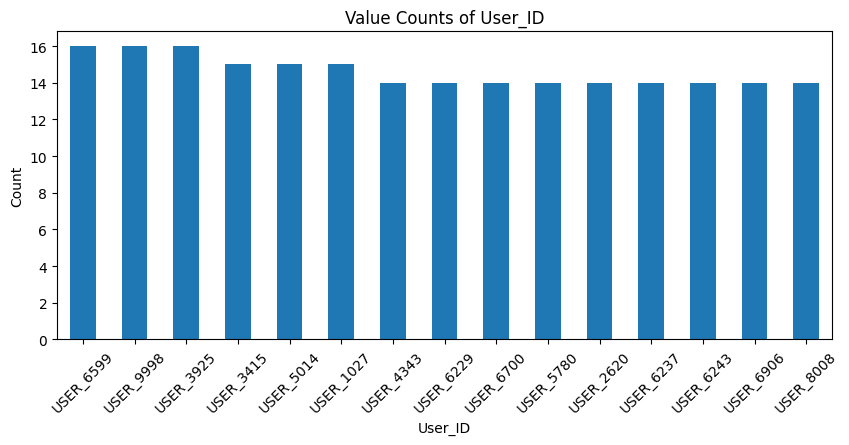

Unique values in 'User_ID': 8963

Value counts for User_ID:
 User_ID
USER_6599    16
USER_9998    16
USER_3925    16
USER_3415    15
USER_5014    15
             ..
USER_4000     1
USER_1501     1
USER_5657     1
USER_8613     1
USER_5580     1
Name: count, Length: 8963, dtype: int64

Top 10 values for User_ID:
 User_ID
USER_6599    16
USER_9998    16
USER_3925    16
USER_3415    15
USER_5014    15
USER_1027    15
USER_4343    14
USER_6229    14
USER_6700    14
USER_5780    14
Name: count, dtype: int64
------------------------------------------------------------


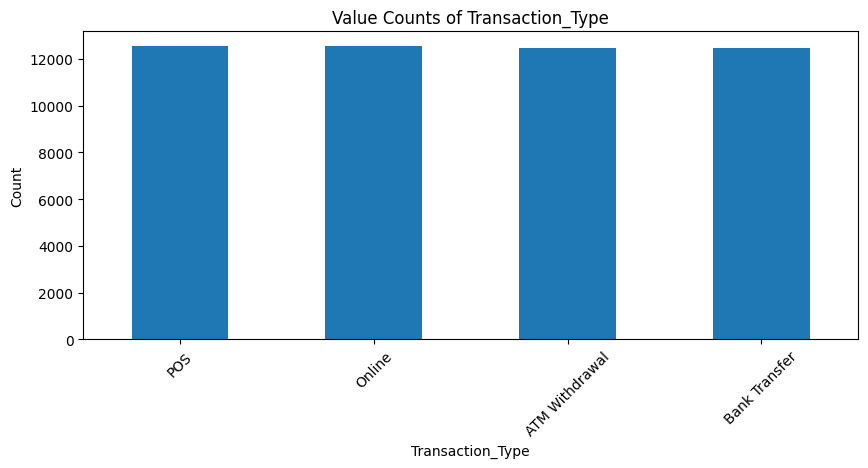

Unique values in 'Transaction_Type': 4

Value counts for Transaction_Type:
 Transaction_Type
POS               12549
Online            12546
ATM Withdrawal    12453
Bank Transfer     12452
Name: count, dtype: int64

Top 10 values for Transaction_Type:
 Transaction_Type
POS               12549
Online            12546
ATM Withdrawal    12453
Bank Transfer     12452
Name: count, dtype: int64
------------------------------------------------------------


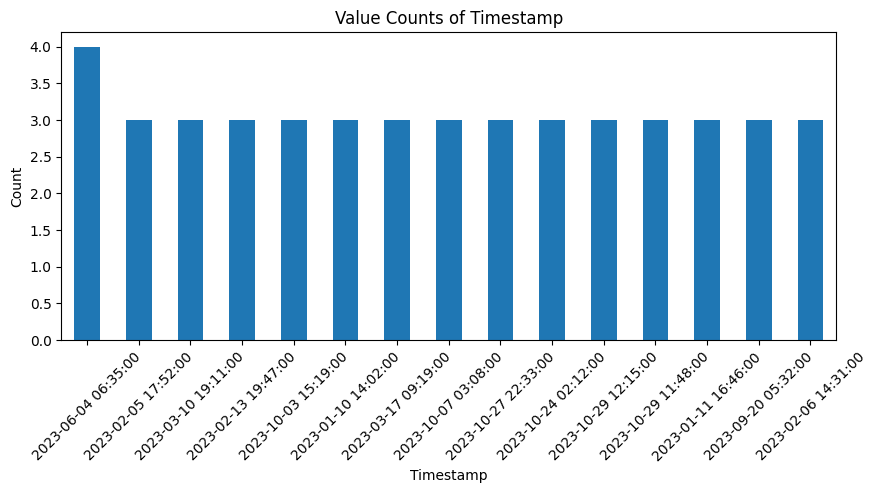

Unique values in 'Timestamp': 47724

Value counts for Timestamp:
 Timestamp
2023-06-04 06:35:00    4
2023-02-05 17:52:00    3
2023-03-10 19:11:00    3
2023-02-13 19:47:00    3
2023-10-03 15:19:00    3
                      ..
2023-01-29 18:38:00    1
2023-05-09 08:55:00    1
2023-01-30 19:32:00    1
2023-03-09 19:47:00    1
2023-06-05 20:55:00    1
Name: count, Length: 47724, dtype: int64

Top 10 values for Timestamp:
 Timestamp
2023-06-04 06:35:00    4
2023-02-05 17:52:00    3
2023-03-10 19:11:00    3
2023-02-13 19:47:00    3
2023-10-03 15:19:00    3
2023-01-10 14:02:00    3
2023-03-17 09:19:00    3
2023-10-07 03:08:00    3
2023-10-27 22:33:00    3
2023-10-24 02:12:00    3
Name: count, dtype: int64
------------------------------------------------------------


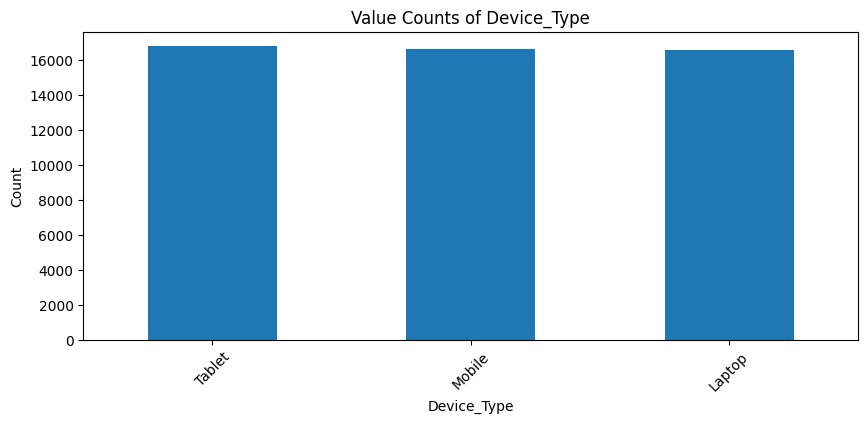

Unique values in 'Device_Type': 3

Value counts for Device_Type:
 Device_Type
Tablet    16779
Mobile    16640
Laptop    16581
Name: count, dtype: int64

Top 10 values for Device_Type:
 Device_Type
Tablet    16779
Mobile    16640
Laptop    16581
Name: count, dtype: int64
------------------------------------------------------------


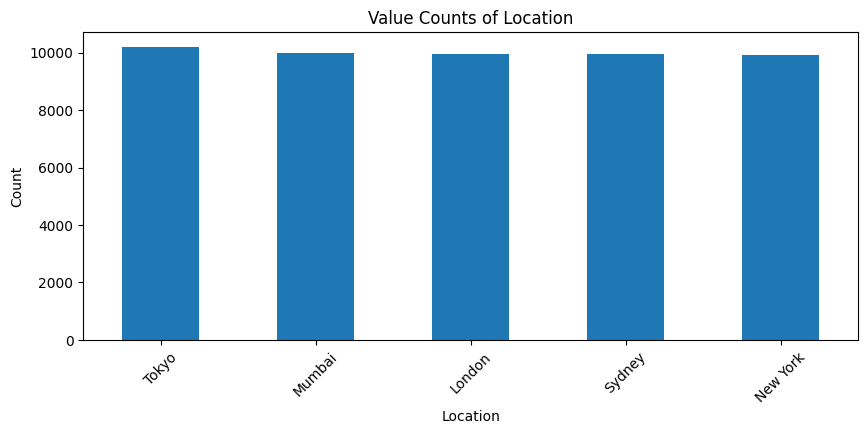

Unique values in 'Location': 5

Value counts for Location:
 Location
Tokyo       10208
Mumbai       9994
London       9945
Sydney       9938
New York     9915
Name: count, dtype: int64

Top 10 values for Location:
 Location
Tokyo       10208
Mumbai       9994
London       9945
Sydney       9938
New York     9915
Name: count, dtype: int64
------------------------------------------------------------


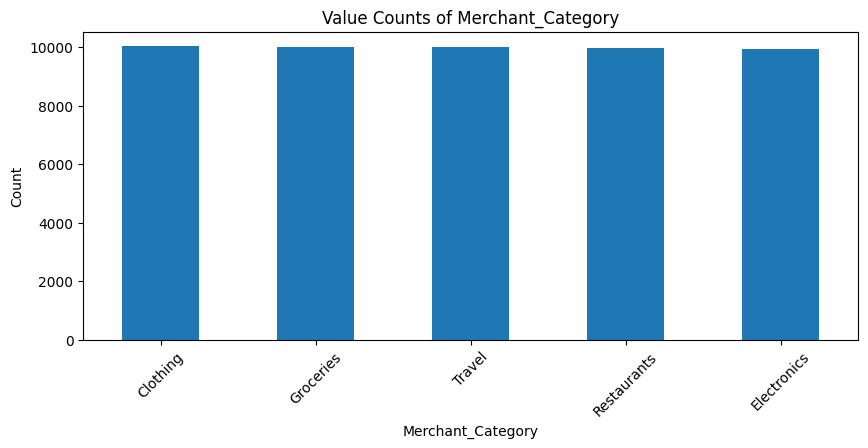

Unique values in 'Merchant_Category': 5

Value counts for Merchant_Category:
 Merchant_Category
Clothing       10033
Groceries      10019
Travel         10015
Restaurants     9976
Electronics     9957
Name: count, dtype: int64

Top 10 values for Merchant_Category:
 Merchant_Category
Clothing       10033
Groceries      10019
Travel         10015
Restaurants     9976
Electronics     9957
Name: count, dtype: int64
------------------------------------------------------------


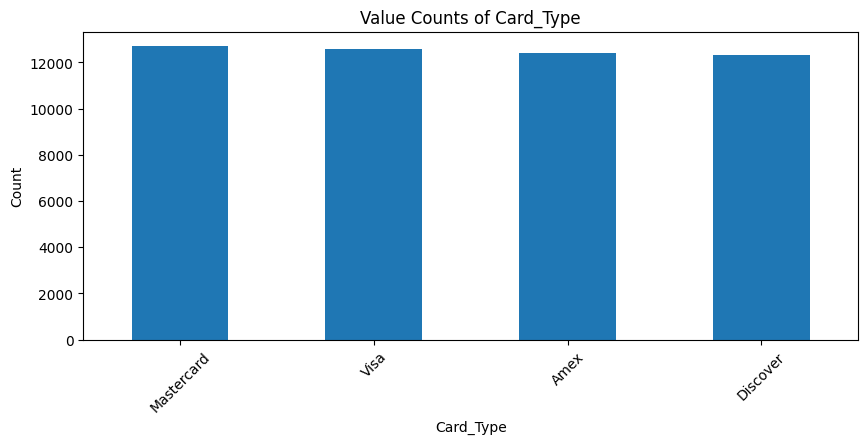

Unique values in 'Card_Type': 4

Value counts for Card_Type:
 Card_Type
Mastercard    12693
Visa          12560
Amex          12419
Discover      12328
Name: count, dtype: int64

Top 10 values for Card_Type:
 Card_Type
Mastercard    12693
Visa          12560
Amex          12419
Discover      12328
Name: count, dtype: int64
------------------------------------------------------------


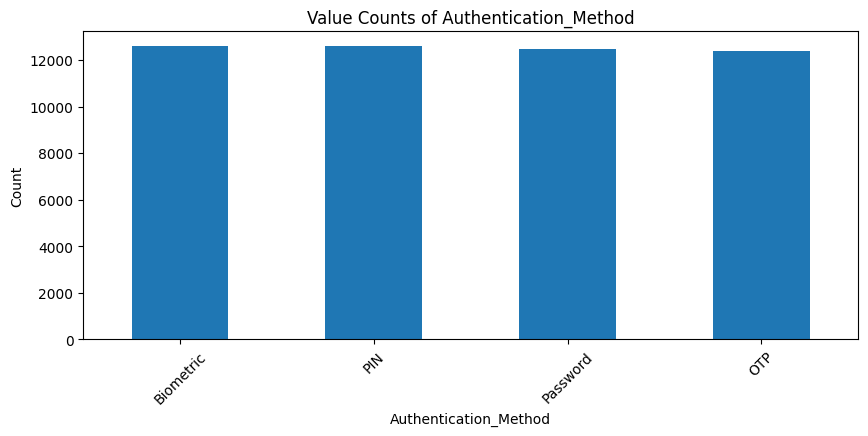

Unique values in 'Authentication_Method': 4

Value counts for Authentication_Method:
 Authentication_Method
Biometric    12591
PIN          12586
Password     12457
OTP          12366
Name: count, dtype: int64

Top 10 values for Authentication_Method:
 Authentication_Method
Biometric    12591
PIN          12586
Password     12457
OTP          12366
Name: count, dtype: int64
------------------------------------------------------------


In [17]:
for col in categorical_cols:
    plt.figure(figsize=(10,4))
    data[col].value_counts().head(15).plot(kind='bar')
    plt.title(f"Value Counts of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

    # Print unique value count
    print(f"Unique values in '{col}': {data[col].nunique()}")
    
    # Print full count of all categories
    print(f"\nValue counts for {col}:\n", data[col].value_counts())
    
    # Print only the top 10 for readability
    print(f"\nTop 10 values for {col}:\n", data[col].value_counts().head(10))
    
    print("-"*60)


### Transaction_ID column has no predictive value and will be removed before modeling.
##### Timestamp
Must be converted into derived features, such as:

Hour of the day

Day of week

Month

Weekend/weekday

Transaction time gap

In [18]:
# Drop the the personal identification columns
data.drop('Transaction_ID', axis=1, inplace=True)
data.drop('User_ID', axis=1, inplace=True)

In [19]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

data['Hour'] = data['Timestamp'].dt.hour
data['DayOfWeek'] = data['Timestamp'].dt.dayofweek
data['Month'] = data['Timestamp'].dt.month
data.drop('Timestamp', axis=1, inplace=True)

In [20]:
data

,Transaction_Amount,Transaction_Type,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,Avg_Transaction_Amount_7d,...,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label,Transaction_Amount_Log,Hour,DayOfWeek,Month
0,39.79,POS,93213.17,Laptop,Sydney,Travel,0,0,7,437.63,...,65,883.17,Biometric,0.8494,0,0,3.708437,19,0,8
1,1.19,Bank Transfer,75725.25,Mobile,New York,Clothing,0,0,13,478.76,...,186,2203.36,Password,0.0959,0,1,0.783902,4,2,6
2,28.96,Online,1588.96,Tablet,Mumbai,Restaurants,0,0,14,50.01,...,226,1909.29,Biometric,0.8400,0,1,3.399863,15,1,6
3,254.32,ATM Withdrawal,76807.20,Tablet,New York,Clothing,0,0,8,182.48,...,76,1311.86,OTP,0.7935,0,1,5.542518,0,3,12
4,31.28,POS,92354.66,Mobile,Mumbai,Electronics,0,1,14,328.69,...,140,966.98,Password,0.3819,1,1,3.474448,23,5,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,45.05,Online,76960.11,Mobile,Tokyo,Clothing,0,0,2,389.00,...,98,1537.54,PIN,0.1493,1,0,3.829728,18,6,1
49996,126.15,POS,28791.75,Mobile,Tokyo,Clothing,0,0,13,434.95,...,93,2555.72,Biometric,0.3653,0,1,4.845367,8,1,5
49997,72.02,Online,29916.41,Laptop,Mumbai,Clothing,0,1,1,369.15,...,114,4686.59,Biometric,0.5195,0,0,4.290733,19,0,1
49998,64.89,Bank Transfer,67895.67,Mobile,Tokyo,Electronics,0,0,13,242.29,...,72,4886.92,Biometric,0.7063,0,1,4.187987,19,3,3


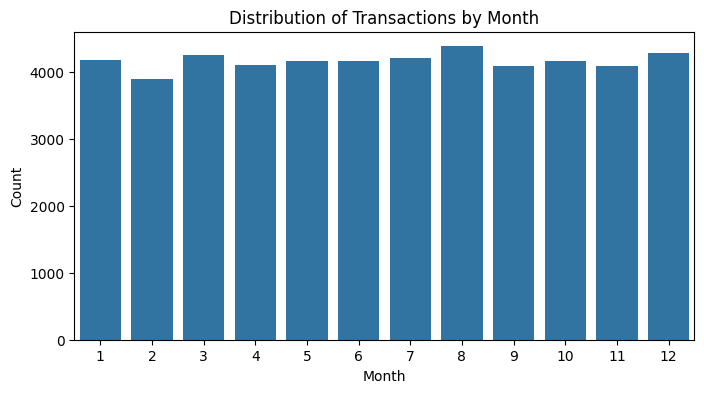

In [21]:
plt.figure(figsize=(8,4))
sns.countplot(x=data['Month'])
plt.title("Distribution of Transactions by Month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.show()

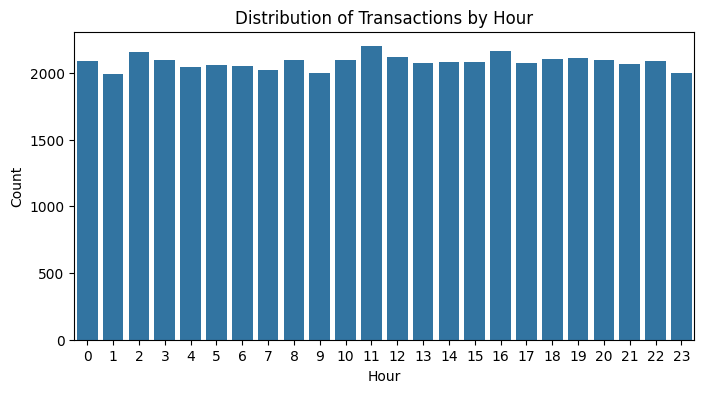

In [22]:
plt.figure(figsize=(8,4))
sns.countplot(x=data['Hour'])
plt.title("Distribution of Transactions by Hour")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.show()

In [23]:
### as they are constant it will not add any value to the model so dropping them
data.drop(['Hour', 'Month',"DayOfWeek"], axis=1, inplace=True)

In [24]:
data.head()

,Transaction_Amount,Transaction_Type,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Type,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label,Transaction_Amount_Log
0,39.79,POS,93213.17,Laptop,Sydney,Travel,0,0,7,437.63,3,Amex,65,883.17,Biometric,0.8494,0,0,3.708437
1,1.19,Bank Transfer,75725.25,Mobile,New York,Clothing,0,0,13,478.76,4,Mastercard,186,2203.36,Password,0.0959,0,1,0.783902
2,28.96,Online,1588.96,Tablet,Mumbai,Restaurants,0,0,14,50.01,4,Visa,226,1909.29,Biometric,0.8400,0,1,3.399863
3,254.32,ATM Withdrawal,76807.20,Tablet,New York,Clothing,0,0,8,182.48,4,Visa,76,1311.86,OTP,0.7935,0,1,5.542518
4,31.28,POS,92354.66,Mobile,Mumbai,Electronics,0,1,14,328.69,4,Mastercard,140,966.98,Password,0.3819,1,1,3.474448


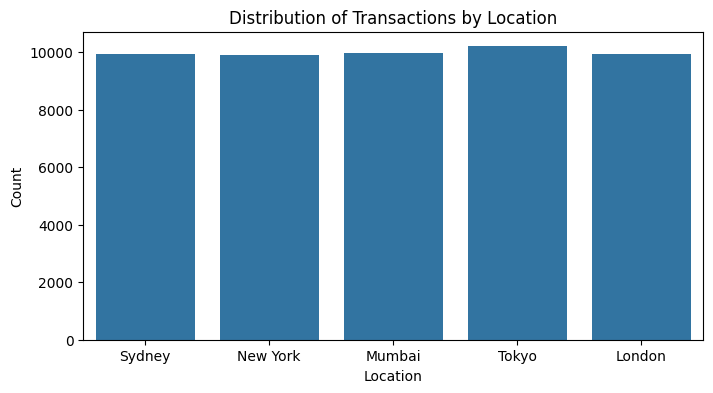

In [25]:
plt.figure(figsize=(8,4))
sns.countplot(x=data['Location'])
plt.title("Distribution of Transactions by Location")
plt.xlabel("Location")
plt.ylabel("Count")
plt.show()

In [26]:
## as the location is not necessary so i am droping the location column
data.drop('Location', axis=1, inplace=True)

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Transaction_Amount            50000 non-null  float64
 1   Transaction_Type              50000 non-null  object 
 2   Account_Balance               50000 non-null  float64
 3   Device_Type                   50000 non-null  object 
 4   Merchant_Category             50000 non-null  object 
 5   IP_Address_Flag               50000 non-null  int64  
 6   Previous_Fraudulent_Activity  50000 non-null  int64  
 7   Daily_Transaction_Count       50000 non-null  int64  
 8   Avg_Transaction_Amount_7d     50000 non-null  float64
 9   Failed_Transaction_Count_7d   50000 non-null  int64  
 10  Card_Type                     50000 non-null  object 
 11  Card_Age                      50000 non-null  int64  
 12  Transaction_Distance          50000 non-null  float64
 13  A

In [28]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Transaction_Amount,50000.0,99.411012,98.687292,0.0000,28.677500,69.66000,138.852500,1174.140000
Account_Balance,50000.0,50294.065981,28760.458557,500.4800,25355.995000,50384.43000,75115.135000,99998.310000
IP_Address_Flag,50000.0,0.050200,0.218360,0.0000,0.000000,0.00000,0.000000,1.000000
Previous_Fraudulent_Activity,50000.0,0.098400,0.297858,0.0000,0.000000,0.00000,0.000000,1.000000
Daily_Transaction_Count,50000.0,7.485240,4.039637,1.0000,4.000000,7.00000,11.000000,14.000000
Avg_Transaction_Amount_7d,50000.0,255.271924,141.382279,10.0000,132.087500,256.08500,378.032500,500.000000
Failed_Transaction_Count_7d,50000.0,2.003540,1.414273,0.0000,1.000000,2.00000,3.000000,4.000000
Card_Age,50000.0,119.999940,68.985817,1.0000,60.000000,120.00000,180.000000,239.000000
Transaction_Distance,50000.0,2499.164155,1442.013834,0.2500,1256.497500,2490.78500,3746.395000,4999.930000
Risk_Score,50000.0,0.501556,0.287774,0.0001,0.254000,0.50225,0.749525,1.000000


## Bivariate Analysis (Numerical vs Fraud_Label)

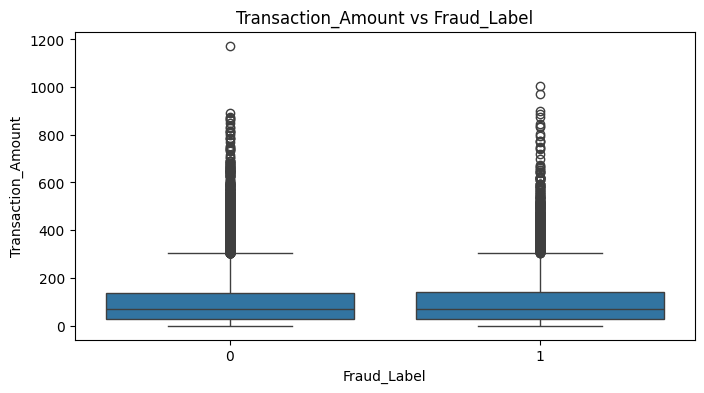

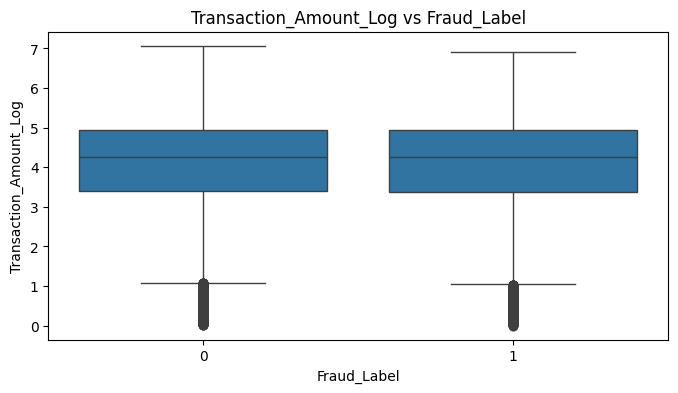

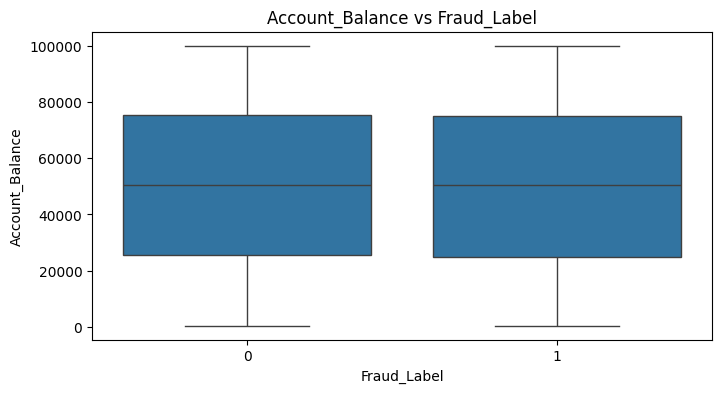

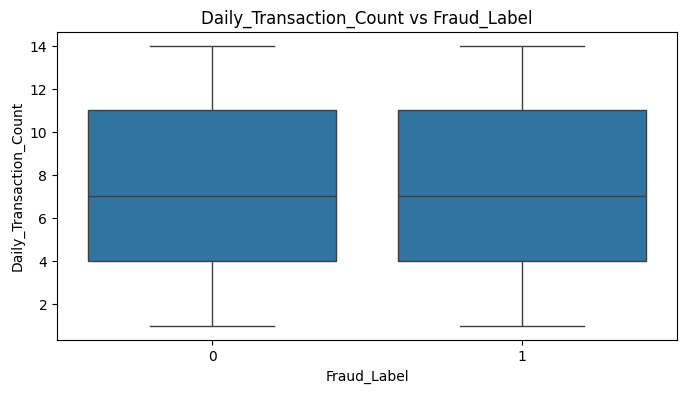

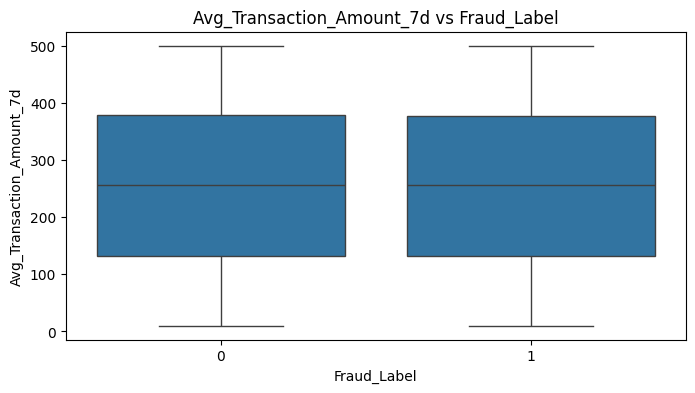

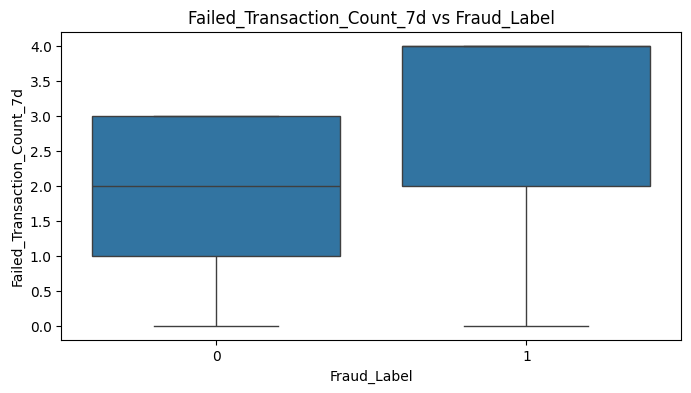

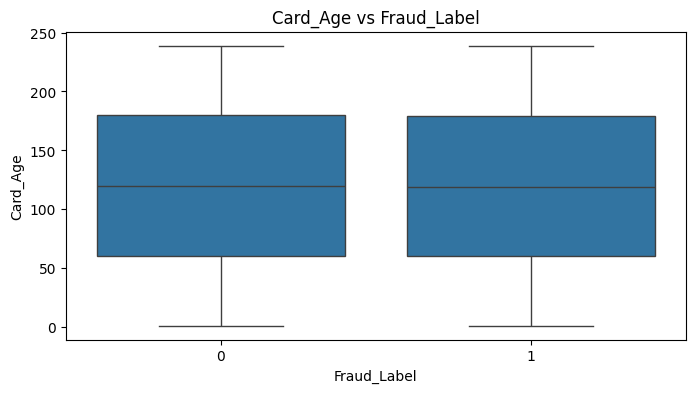

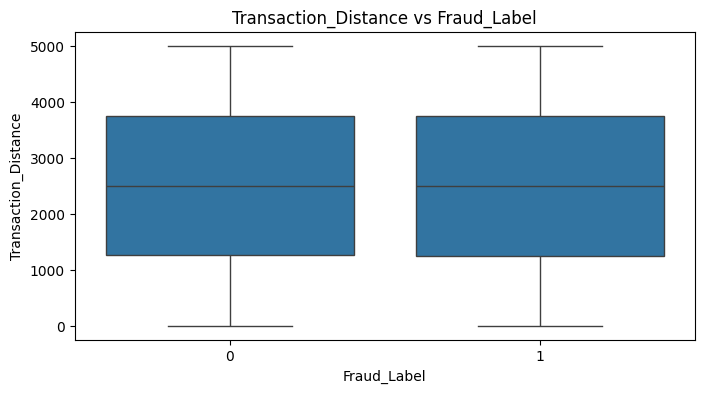

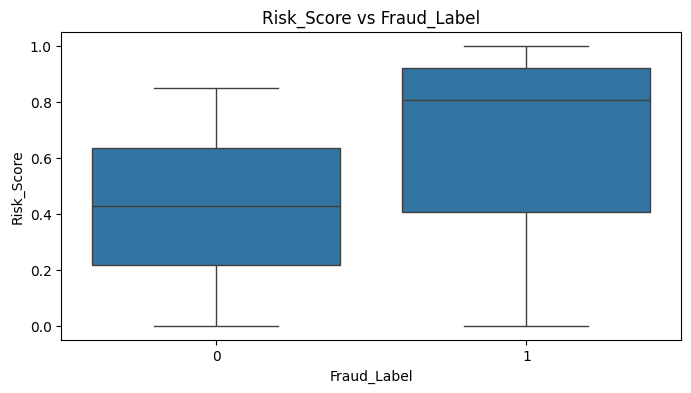

In [29]:
numerical_cols = [
    'Transaction_Amount', 'Transaction_Amount_Log', 'Account_Balance',
    'Daily_Transaction_Count', 'Avg_Transaction_Amount_7d',
    'Failed_Transaction_Count_7d', 'Card_Age', 'Transaction_Distance',
    'Risk_Score'
]

for col in numerical_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(data=data, x='Fraud_Label', y=col)
    plt.title(f"{col} vs Fraud_Label")
    plt.show()


In [30]:
for col in numerical_cols:
    print(f"\nColumn: {col}")
    print(data.groupby('Fraud_Label')[col].mean())
    print("-"*40)



Column: Transaction_Amount
Fraud_Label
0    99.281907
1    99.683678
Name: Transaction_Amount, dtype: float64
----------------------------------------

Column: Transaction_Amount_Log
Fraud_Label
0    4.075458
1    4.075767
Name: Transaction_Amount_Log, dtype: float64
----------------------------------------

Column: Account_Balance
Fraud_Label
0    50356.472852
1    50162.264626
Name: Account_Balance, dtype: float64
----------------------------------------

Column: Daily_Transaction_Count
Fraud_Label
0    7.504877
1    7.443767
Name: Daily_Transaction_Count, dtype: float64
----------------------------------------

Column: Avg_Transaction_Amount_7d
Fraud_Label
0    255.20353
1    255.41637
Name: Avg_Transaction_Amount_7d, dtype: float64
----------------------------------------

Column: Failed_Transaction_Count_7d
Fraud_Label
0    1.507353
1    3.051472
Name: Failed_Transaction_Count_7d, dtype: float64
----------------------------------------

Column: Card_Age
Fraud_Label
0    120.14805

In [31]:
from scipy.stats import ttest_ind

for col in numerical_cols:
    fraud = data[data['Fraud_Label']==1][col]
    nonfraud = data[data['Fraud_Label']==0][col]

    t_stat, p_val = ttest_ind(fraud, nonfraud, equal_var=False)
    print(f"{col}: p-value = {p_val}")


Transaction_Amount: p-value = 0.6715425034092659
Transaction_Amount_Log: p-value = 0.9782594291370077
Account_Balance: p-value = 0.481191170605502
Daily_Transaction_Count: p-value = 0.11411659739526905
Avg_Transaction_Amount_7d: p-value = 0.8748685535426952
Failed_Transaction_Count_7d: p-value = 0.0
Card_Age: p-value = 0.4851357603615454
Transaction_Distance: p-value = 0.9794508827927133
Risk_Score: p-value = 0.0


In [32]:
categorical_cols = [
    'Transaction_Type',
    'Device_Type',
    'Merchant_Category',
    'Card_Type',
    'Authentication_Method'
]


In [33]:
for col in categorical_cols:
    fraud_rate = data.groupby(col)['Fraud_Label'].mean().sort_values(ascending=False)

    print(f"\nFraud Rate by {col}:\n")
    print(fraud_rate)
    print("-"*60)



Fraud Rate by Transaction_Type:

Transaction_Type
ATM Withdrawal    0.324902
Online            0.321298
Bank Transfer     0.320832
POS               0.318352
Name: Fraud_Label, dtype: float64
------------------------------------------------------------

Fraud Rate by Device_Type:

Device_Type
Tablet    0.325645
Laptop    0.319522
Mobile    0.318810
Name: Fraud_Label, dtype: float64
------------------------------------------------------------

Fraud Rate by Merchant_Category:

Merchant_Category
Restaurants    0.326283
Travel         0.323015
Groceries      0.321090
Electronics    0.319273
Clothing       0.317054
Name: Fraud_Label, dtype: float64
------------------------------------------------------------

Fraud Rate by Card_Type:

Card_Type
Discover      0.324951
Amex          0.323778
Visa          0.318631
Mastercard    0.318128
Name: Fraud_Label, dtype: float64
------------------------------------------------------------

Fraud Rate by Authentication_Method:

Authentication_Method


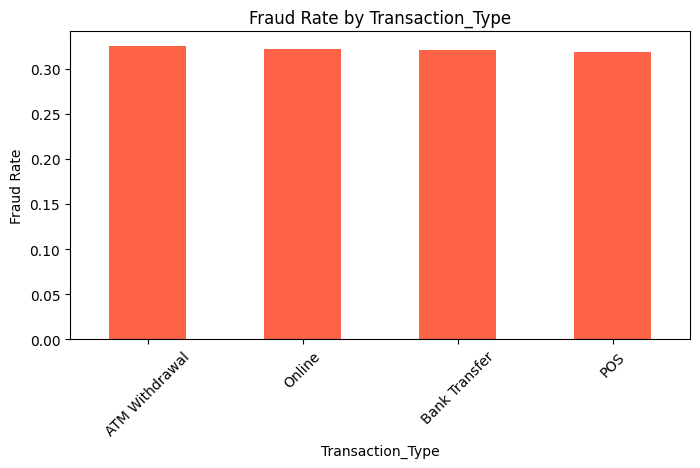

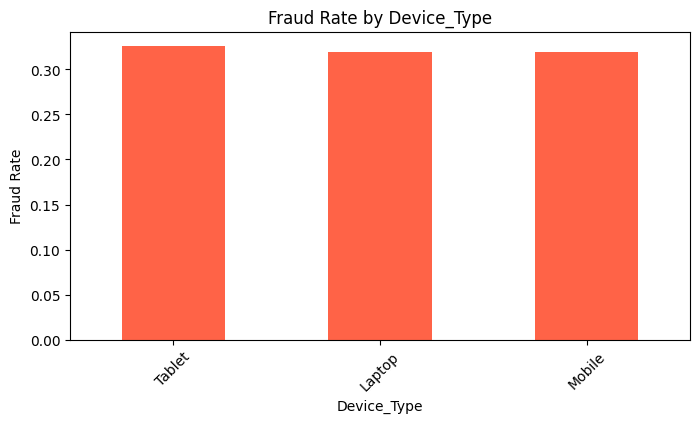

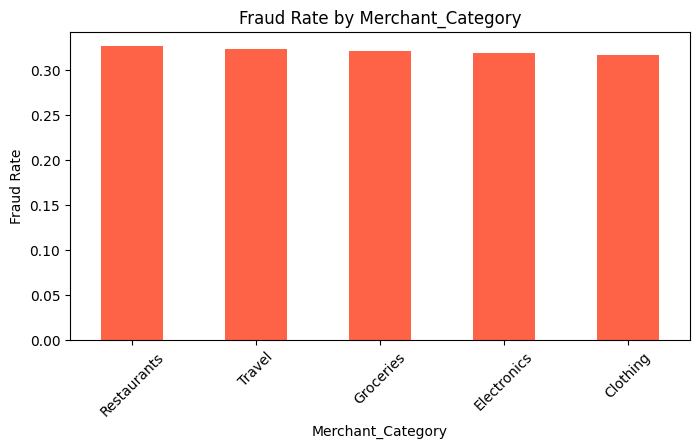

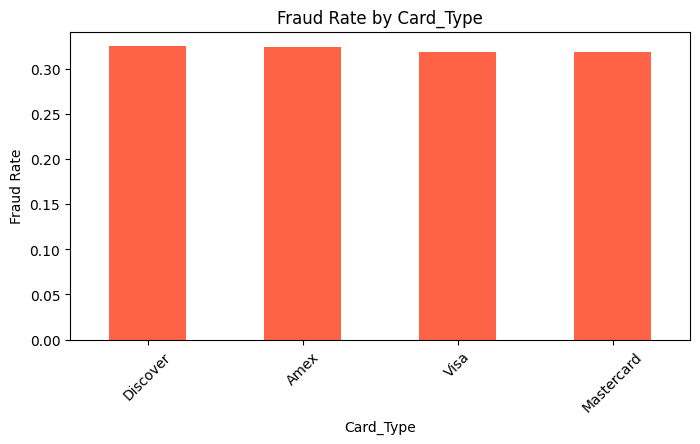

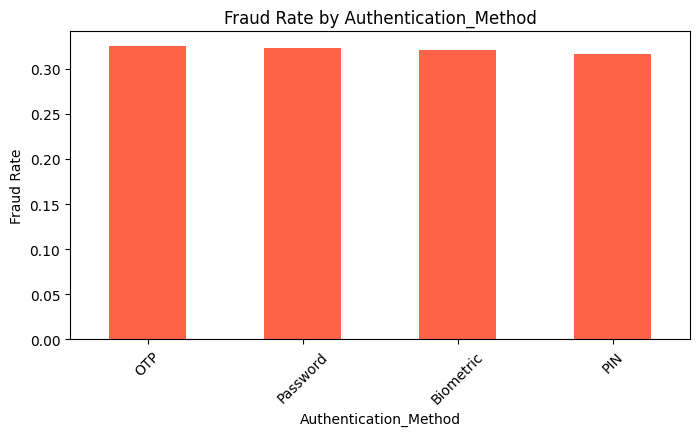

In [34]:
for col in categorical_cols:
    plt.figure(figsize=(8,4))
    
    fraud_rate = data.groupby(col)['Fraud_Label'].mean().sort_values(ascending=False)
    fraud_rate.plot(kind='bar', color='tomato')
    
    plt.title(f"Fraud Rate by {col}")
    plt.ylabel("Fraud Rate")
    plt.xlabel(col)
    plt.xticks(rotation=45)
    
    plt.show()


In [35]:
corr = data[numerical_cols].corr()
corr


,Transaction_Amount,Transaction_Amount_Log,Account_Balance,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Age,Transaction_Distance,Risk_Score
Transaction_Amount,1.000000,0.812731,-0.002380,0.002149,-0.006255,0.001247,0.002294,0.007935,0.005606
Transaction_Amount_Log,0.812731,1.000000,0.004495,-0.001869,-0.004660,0.001604,-0.003282,0.001600,0.005483
Account_Balance,-0.002380,0.004495,1.000000,0.006041,-0.001738,-0.000186,0.000717,0.001748,-0.005262
Daily_Transaction_Count,0.002149,-0.001869,0.006041,1.000000,0.004882,-0.007820,-0.001516,-0.001842,-0.007572
Avg_Transaction_Amount_7d,-0.006255,-0.004660,-0.001738,0.004882,1.000000,0.006583,-0.008735,-0.003066,0.004977
Failed_Transaction_Count_7d,0.001247,0.001604,-0.000186,-0.007820,0.006583,1.000000,-0.004570,-0.006997,0.000814
Card_Age,0.002294,-0.003282,0.000717,-0.001516,-0.008735,-0.004570,1.000000,-0.003339,-0.001385
Transaction_Distance,0.007935,0.001600,0.001748,-0.001842,-0.003066,-0.006997,-0.003339,1.000000,-0.001902
Risk_Score,0.005606,0.005483,-0.005262,-0.007572,0.004977,0.000814,-0.001385,-0.001902,1.000000


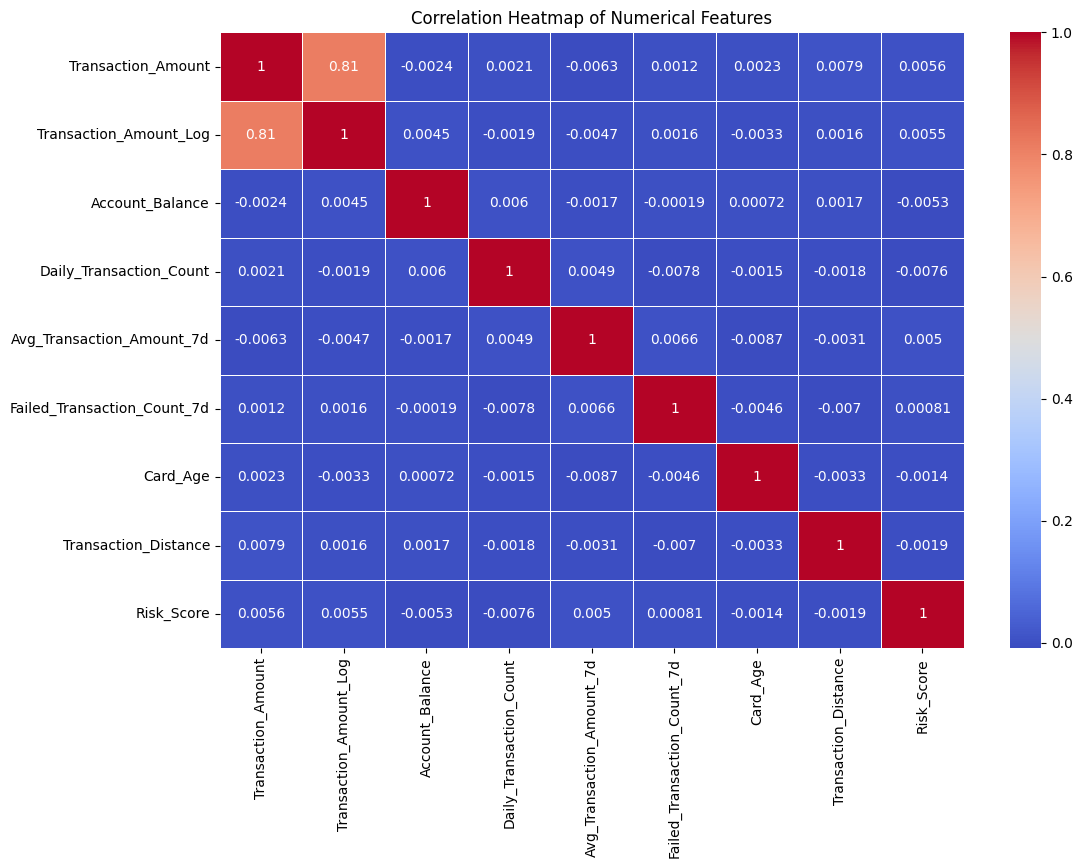

In [36]:
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


In [37]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['Fraud_Label'])
y = data['Fraud_Label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [38]:
categorical_cols = [
    'Transaction_Type',
    'Device_Type',
    'Merchant_Category',
    'Card_Type',
    'Authentication_Method'
]

for col in categorical_cols:
    print(f"{col} → {data[col].nunique()} unique values")
    print(data[col].unique())
    print("-" * 60)


Transaction_Type → 4 unique values
['POS' 'Bank Transfer' 'Online' 'ATM Withdrawal']
------------------------------------------------------------
Device_Type → 3 unique values
['Laptop' 'Mobile' 'Tablet']
------------------------------------------------------------
Merchant_Category → 5 unique values
['Travel' 'Clothing' 'Restaurants' 'Electronics' 'Groceries']
------------------------------------------------------------
Card_Type → 4 unique values
['Amex' 'Mastercard' 'Visa' 'Discover']
------------------------------------------------------------
Authentication_Method → 4 unique values
['Biometric' 'Password' 'OTP' 'PIN']
------------------------------------------------------------


In [39]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = [
    'Transaction_Type', 'Device_Type',
    'Merchant_Category', 'Card_Type',
    'Authentication_Method'
]

encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
    encoders[col] = le


In [40]:
X_train.head()

,Transaction_Amount,Transaction_Type,Account_Balance,Device_Type,Merchant_Category,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Type,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Transaction_Amount_Log
3133,2.55,3,96419.93,1,2,0,0,6,77.85,3,0,69,598.75,0,0.5162,0,1.266948
5433,76.35,1,70407.92,1,1,0,1,2,276.38,1,0,41,4241.83,3,0.7351,0,4.348341
7621,9.22,0,5796.72,1,3,0,0,7,262.68,1,2,80,3202.19,1,0.1946,1,2.324347
22601,173.76,2,98719.65,1,4,0,0,10,168.91,1,1,228,2576.61,1,0.5666,0,5.163414
40066,3.60,1,5928.75,1,0,0,0,8,82.67,3,2,102,1692.09,2,0.5073,0,1.526056


In [41]:
# Create model
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss"
)

# Train model
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nROC-AUC Score:")
print(roc_auc_score(y_test, y_prob))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6787
           1       1.00      1.00      1.00      3213

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000


ROC-AUC Score:
0.9999979822651193

Confusion Matrix:
[[6782    5]
 [   4 3209]]


In [42]:
# Drop Risk_Score from training and test features
X_train = X_train.drop(columns=['Risk_Score'])
X_test = X_test.drop(columns=['Risk_Score'])
X_train.head()

,Transaction_Amount,Transaction_Type,Account_Balance,Device_Type,Merchant_Category,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Type,Card_Age,Transaction_Distance,Authentication_Method,Is_Weekend,Transaction_Amount_Log
3133,2.55,3,96419.93,1,2,0,0,6,77.85,3,0,69,598.75,0,0,1.266948
5433,76.35,1,70407.92,1,1,0,1,2,276.38,1,0,41,4241.83,3,0,4.348341
7621,9.22,0,5796.72,1,3,0,0,7,262.68,1,2,80,3202.19,1,1,2.324347
22601,173.76,2,98719.65,1,4,0,0,10,168.91,1,1,228,2576.61,1,0,5.163414
40066,3.60,1,5928.75,1,0,0,0,8,82.67,3,2,102,1692.09,2,0,1.526056


In [43]:
# Train model
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nROC-AUC Score:")
print(roc_auc_score(y_test, y_prob))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      6787
           1       1.00      0.62      0.76      3213

    accuracy                           0.88     10000
   macro avg       0.92      0.81      0.84     10000
weighted avg       0.90      0.88      0.87     10000


ROC-AUC Score:
0.8106323943391347

Confusion Matrix:
[[6783    4]
 [1227 1986]]


In [44]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
from sklearn.metrics import make_scorer, roc_auc_score

In [45]:
## hyperparameter tuning using RandomizedSearchCV
param_dist = {
    "n_estimators": randint(200, 800),
    "max_depth": randint(3, 12),
    "learning_rate": uniform(0.01, 0.2),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4),
    "gamma": uniform(0, 5),
    "min_child_weight": randint(1, 10),
}

# imbalance ratio
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# -----------------------------
# Base classifier model
# -----------------------------
xgb_clf = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",         # use 'gpu_hist' if you have GPU
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

# -----------------------------
# Randomized Search CV setup
# -----------------------------
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=40,                   # number of random combinations
    scoring="roc_auc",           # BEST metric for fraud detection
    cv=3,                        # 3-fold CV for speed
    verbose=2,
    n_jobs=-1
)

# -----------------------------
# Run hyperparameter search
# -----------------------------
random_search.fit(X_train, y_train)

# -----------------------------
# Output best results
# -----------------------------
print("Best parameters:", random_search.best_params_)
print("Best CV ROC-AUC:", random_search.best_score_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best parameters: {'colsample_bytree': np.float64(0.9361528818247061), 'gamma': np.float64(2.3297006120644905), 'learning_rate': np.float64(0.07338877002834186), 'max_depth': 8, 'min_child_weight': 9, 'n_estimators': 685, 'subsample': np.float64(0.7025789071504717)}
Best CV ROC-AUC: 0.8141474888855359


In [46]:


# Best parameters from tuning
best_params = {
    'colsample_bytree': 0.9361528818247061,
    'gamma': 2.3297006120644905,
    'learning_rate': 0.07338877002834186,
    'max_depth': 8,
    'min_child_weight': 9,
    'n_estimators': 685,
    'subsample': 0.7025789071504717
}

# Optional additions (recommended)
best_params.update({
    'random_state': 42,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'n_jobs': -1
})

# Create final model
final_model = XGBClassifier(**best_params)

# Train model
final_model.fit(X_train, y_train)

# Predictions (use final_model)
y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)[:, 1]

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nROC-AUC Score:")
print(roc_auc_score(y_test, y_prob))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Save model (optional)
# joblib.dump(final_model, "xgb_final_model.joblib")


Classification Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      6787
           1       1.00      0.62      0.76      3213

    accuracy                           0.88     10000
   macro avg       0.92      0.81      0.84     10000
weighted avg       0.90      0.88      0.87     10000


ROC-AUC Score:
0.8107235821984606

Confusion Matrix:
[[6787    0]
 [1228 1985]]


In [47]:
# Save model (optional)
joblib.dump(final_model, "xgb_final_model.joblib")

['xgb_final_model.joblib']

In [51]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

model_lgb = LGBMClassifier(
    objective='binary',
    learning_rate=0.05,
    num_leaves=31,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=1,
    scale_pos_weight=scale_pos_weight,
    n_estimators=300,   # reduce because no early stopping
    random_state=42
)

model_lgb.fit(X_train, y_train)

# Predictions
y_prob_lgb = model_lgb.predict_proba(X_test)[:, 1]
y_pred_lgb = model_lgb.predict(X_test)

print("LightGBM ROC-AUC:", roc_auc_score(y_test, y_prob_lgb))
print(classification_report(y_test, y_pred_lgb))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_lgb))


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 12854, number of negative: 27146
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Ligh

In [53]:
joblib.dump(encoders, "label_encoders.joblib")


['label_encoders.joblib']

In [54]:
joblib.dump(list(X_train.columns), "feature_columns.joblib")


['feature_columns.joblib']

In [ ]:
## checking the dumped file

In [55]:
import joblib
import pandas as pd

# -----------------------------
# Load model + encoders + columns
# -----------------------------
model = joblib.load("xgb_final_model.joblib")
encoders = joblib.load("label_encoders.joblib")
feature_columns = joblib.load("feature_columns.joblib")

# -----------------------------
# Preprocessing function
# -----------------------------
def preprocess_input(input_dict):
    """
    input_dict: python dictionary with raw input (one sample)
    Converts it to a DataFrame with encoded categorical variables.
    """
    
    # Convert dictionary → DataFrame
    df = pd.DataFrame([input_dict])

    # Apply label encoders to categorical columns
    for col, le in encoders.items():
        if col in df.columns:
            df[col] = le.transform(df[col])

    # Add missing columns if required (safety)
    for col in feature_columns:
        if col not in df.columns:
            df[col] = 0  # or np.nan depending on use case

    # Ensure correct column order
    df = df[feature_columns]

    return df


# -----------------------------
# Prediction function
# -----------------------------
def predict_fraud(input_dict, threshold=0.5):
    """
    Returns: probability of fraud, predicted label
    """
    df = preprocess_input(input_dict)

    prob = model.predict_proba(df)[0][1]   # fraud probability
    pred = int(prob >= threshold)          # convert to label

    return {
        "fraud_probability": float(prob),
        "fraud_label": pred
    }


In [56]:
sample_input = {
    "Transaction_Amount": 150.75,
    "Transaction_Type": "Online",
    "Account_Balance": 25000,
    "Device_Type": "Mobile",
    "Location": "Mumbai",  
    "Merchant_Category": "Electronics",
    "IP_Address_Flag": 0,
    "Previous_Fraudulent_Activity": 0,
    "Daily_Transaction_Count": 5,
    "Avg_Transaction_Amount_7d": 120.0,
    "Failed_Transaction_Count_7d": 1,
    "Card_Type": "Visa",
    "Card_Age": 36,
    "Transaction_Distance": 500.0,
    "Authentication_Method": "PIN",
    "Is_Weekend": 0
}


In [57]:
result = predict_fraud(sample_input)
print(result)


{'fraud_probability': 0.14430667459964752, 'fraud_label': 0}
